In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

pd.options.mode.chained_assignment = None

In [2]:
grit_stats = pd.read_csv('~/SPECS_phil/stats/grit_scores.csv') # user should change path to stats
root_dir = '/scratch3-shared/phil/berzelius_non_grit_based/' # user should change path to where model run results are located

bf_file = 'bf_11cls_basic_aug_dmsonorm_750e_sgd/ResNet_resnet50/analysis.csv' # change 11c to 10c for without DMSO
fl_file = 'fl_11cls_basic_aug_dmso_norm_750e_sgd/ResNet_resnet50/analysis.csv'
cp_file = 'bf_11cls_basic_aug_dmsonorm_750e_sgd/ResNet_resnet50/cp_moa_analysis.csv'

site_conversion = pd.DataFrame(
    {
        'bf_sites': ['s1', 's2', 's3', 's4', 's5'],
        'fl_sites': ['s2', 's4', 's5', 's6', 's8'],
    }
)

for split in range(1, 6):
    bf_split = pd.read_csv(root_dir + 'bf_exps_1_split' + str(split) + '/' + bf_file, index_col=0)
    bf_split['split'] = np.repeat(split, len(bf_split))
    
    fl_split = pd.read_csv(root_dir + 'fl_exps_1_split' + str(split) + '/' + fl_file, index_col=0)
    fl_split['split'] = np.repeat(split, len(fl_split))
    
    cp_split = pd.read_csv(root_dir + 'bf_exps_1_split' + str(split) + '/' + cp_file)
    cp_split['split'] = np.repeat(split, len(cp_split))
    
    if split == 1:
        bf_df = bf_split
        fl_df = fl_split
        cp_df = cp_split
    else:
        bf_df = pd.concat([bf_df, bf_split], ignore_index=True, sort=False)
        fl_df = pd.concat([fl_df, fl_split], ignore_index=True, sort=False)
        cp_df = pd.concat([cp_df, cp_split], ignore_index=True, sort=False)

bf_df['fl_site'] = bf_df['site'].map(site_conversion.set_index('bf_sites')['fl_sites'])

bf_df = bf_df[bf_df['compound']!='dmso'].reset_index(drop=True)
fl_df = fl_df[fl_df['compound']!='dmso'].reset_index(drop=True)
cp_df = cp_df[cp_df['compound']!='dmso'].reset_index(drop=True)

In [3]:
grit_stats['pws'] = grit_stats['plate'] + grit_stats['well'] + grit_stats['fl_site']

bf_df['pws'] = bf_df['plate'] + bf_df['well'] + bf_df['fl_site']
fl_df['pws'] = fl_df['plate'] + fl_df['well'] + fl_df['site']
cp_df['pws'] = cp_df['plate'] + cp_df['well'] + cp_df['site']

bf_df = bf_df[bf_df.pws.isin(grit_stats.pws)].reset_index(drop=True)
fl_df = fl_df[fl_df.pws.isin(grit_stats.pws)].reset_index(drop=True)
cp_df = cp_df[cp_df.pws.isin(grit_stats.pws)].reset_index(drop=True)

bf_df['grit'] = bf_df['pws'].map(grit_stats.set_index('pws')['grit'])
bf_df['nuclei'] = bf_df['pws'].map(grit_stats.set_index('pws')['nuclei_count'])

fl_df['grit'] = fl_df['pws'].map(grit_stats.set_index('pws')['grit'])
fl_df['nuclei'] = fl_df['pws'].map(grit_stats.set_index('pws')['nuclei_count'])

cp_df['grit'] = cp_df['pws'].map(grit_stats.set_index('pws')['grit'])
cp_df['nuclei'] = cp_df['pws'].map(grit_stats.set_index('pws')['nuclei_count'])

bf_df['correct'] = np.where(bf_df['moa']==bf_df['pred_moa'], 1, 0)
fl_df['correct'] = np.where(fl_df['moa']==fl_df['pred_moa'], 1, 0)
cp_df['correct'] = np.where(cp_df['moa']==cp_df['pred_moa'], 1, 0)

In [4]:
print('GRIT: AUROC scores')
print('BF logistic regression')
nan_rem = ~np.isnan(bf_df[['grit', 'nuclei']].to_numpy()).any(axis=1)

X0 = bf_df[['grit', 'nuclei']].to_numpy()[nan_rem]
scaler = StandardScaler().fit(X0)
X0 = scaler.transform(X0)
X = X0[:, 0].reshape(-1, 1)
y = bf_df['correct'][nan_rem]
clf = LogisticRegression(solver="liblinear", random_state=0).fit(X, y)
print(np.round(roc_auc_score(y, clf.predict_proba(X)[:, 1]), 3))

print('FL logistic regression')
nan_rem = ~np.isnan(fl_df[['grit', 'nuclei']].to_numpy()).any(axis=1)

X0 = fl_df[['grit', 'nuclei']].to_numpy()[nan_rem]
scaler = StandardScaler().fit(X0)
X0 = scaler.transform(X0)
X = X0[:, 0].reshape(-1, 1)
y = fl_df['correct'][nan_rem]
clf = LogisticRegression(solver="liblinear", random_state=0).fit(X, y)
print(np.round(roc_auc_score(y, clf.predict_proba(X)[:, 1]), 3))

print('CP logistic regression')
nan_rem = ~np.isnan(cp_df[['grit', 'nuclei']].to_numpy()).any(axis=1)

X0 = cp_df[['grit', 'nuclei']].to_numpy()[nan_rem]
scaler = StandardScaler().fit(X0)
X0 = scaler.transform(X0)
X = X0[:, 0].reshape(-1, 1)
y = cp_df['correct'][nan_rem]
clf = LogisticRegression(solver="liblinear", random_state=0).fit(X, y)
print(np.round(roc_auc_score(y, clf.predict_proba(X)[:, 1]), 3))

GRIT: AUROC scores
BF logistic regression
0.662
FL logistic regression
0.578
CP logistic regression
0.627


In [5]:
bf_correct = bf_df[bf_df['correct']==1]['grit'].values
bf_false = bf_df[bf_df['correct']==0]['grit'].values

fl_correct = fl_df[fl_df['correct']==1]['grit'].values
fl_false = fl_df[fl_df['correct']==0]['grit'].values

cp_correct = cp_df[cp_df['correct']==1]['grit'].values
cp_false = cp_df[cp_df['correct']==0]['grit'].values

In [6]:
n_bins = 10
y_correct_bf, x=np.histogram(bf_correct, bins=n_bins, range=(0, np.max(bf_df.grit)))
y_false_bf, x=np.histogram(bf_false, bins=n_bins, range=(0, np.max(bf_df.grit)))

y_correct_fl, x=np.histogram(fl_correct, bins=n_bins, range=(0, np.max(bf_df.grit)))
y_false_fl, x=np.histogram(fl_false, bins=n_bins, range=(0, np.max(bf_df.grit)))

y_correct_cp, x=np.histogram(cp_correct, bins=n_bins, range=(0, np.max(bf_df.grit)))
y_false_cp, x=np.histogram(cp_false, bins=n_bins, range=(0, np.max(bf_df.grit)))

res11 = pd.DataFrame(
    {
        'x': x[1:],
        'bf_cor': y_correct_bf,
        'bf_fal': y_false_bf,
        'fl_cor': y_correct_fl,
        'fl_fal': y_false_fl,
        'cp_cor': y_correct_cp,
        'cp_fal': y_false_cp
    }
)

# save csv for use in 'grit_10c_vs_11c.ipynb'
res11.to_csv('~/SPECS_phil/data_tables/grits_correct_11c.csv', index=False) # change to 10c for without DMSO

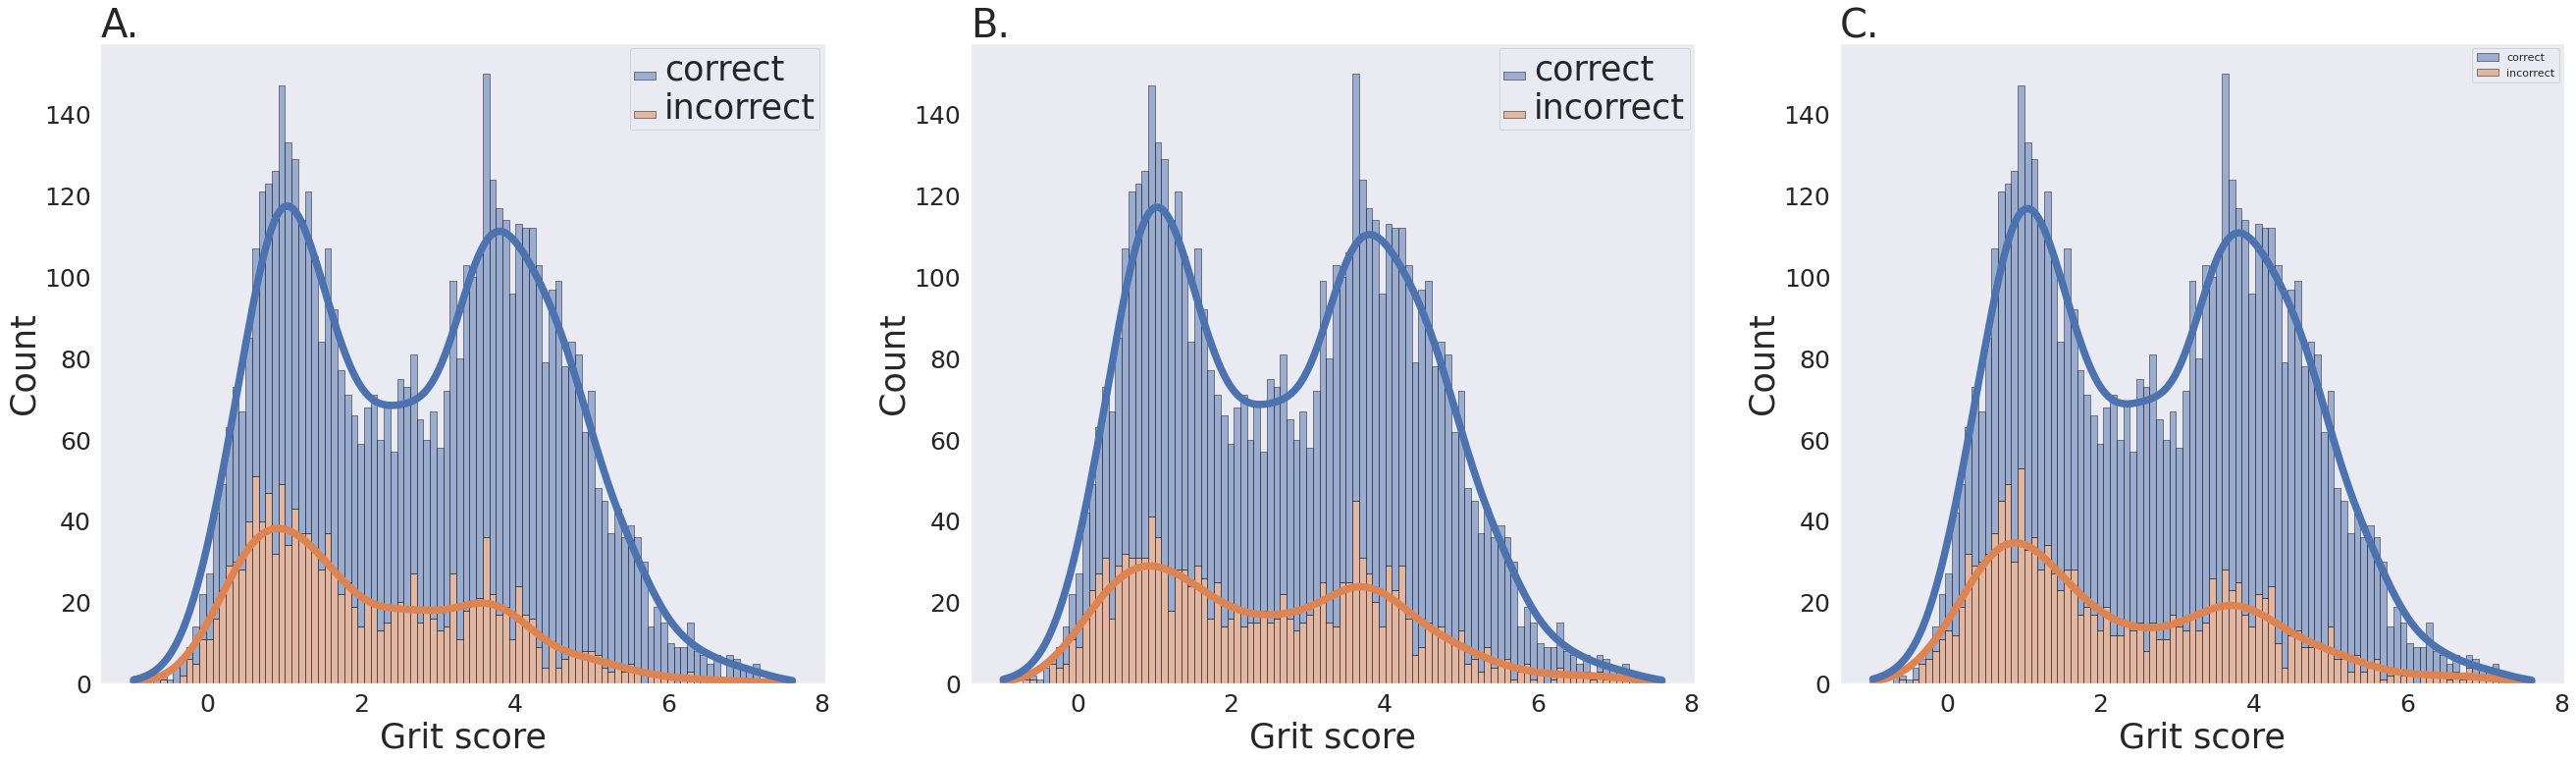

In [7]:
bf_df['prediction'] = np.where(bf_df['moa']==bf_df['pred_moa'], 'correct', 'incorrect')
fl_df['prediction'] = np.where(fl_df['moa']==fl_df['pred_moa'], 'correct', 'incorrect')
cp_df['prediction'] = np.where(cp_df['moa']==cp_df['pred_moa'], 'correct', 'incorrect')

sns.set_theme(style="dark")
fig = plt.figure(figsize=(45,12))

ax = fig.add_subplot(131)
n_bins = 100
ax = sns.histplot(
    bf_df,
    bins=n_bins,
    x="grit", hue="prediction",
    multiple="stack",
    #palette="light:m_r",
    edgecolor=".1",
    linewidth=.5,
    line_kws={'linewidth': 7.5},
    kde=True,
)
ax.legend_.set_title(None)
plt.setp(ax.get_legend().get_texts(), fontsize='35')
ax.set_title('A.', loc='left', fontsize=40)
ax.set_xlabel('Grit score', fontsize=35)
ax.set_ylabel('Count', fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

ax = fig.add_subplot(132)

sns.histplot(
    fl_df,
    bins=n_bins,
    x="grit", hue="prediction",
    hue_order = ["correct", "incorrect"],
    multiple="stack",
    #palette="light:m_r",
    edgecolor=".1",
    linewidth=.5,
    line_kws={'linewidth': 7.5},
    kde=True,
)
ax.legend_.set_title(None)
plt.setp(ax.get_legend().get_texts(), fontsize='35')
ax.set_title('B.', loc='left', fontsize=40)
ax.set_xlabel('Grit score', fontsize=35)
ax.set_ylabel('Count', fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

ax = fig.add_subplot(133)

sns.histplot(
    cp_df,
    bins=n_bins,
    x="grit", hue="prediction",
    hue_order = ["correct", "incorrect"],
    multiple="stack",
    #palette="light:m_r",
    edgecolor=".1",
    linewidth=.5,
    kde=True,
    line_kws={'linewidth': 7.5},
)
ax.legend_.set_title(None)
ax.set_title('C.', loc='left', fontsize=40)
ax.set_xlabel('Grit score', fontsize=35)
ax.set_ylabel('Count', fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.savefig('grit_hist.png', bbox_inches='tight', format='png')

plt.show()
plt.close()